This blog utilizes the Palmer Penguins dataset to develop predictive models for determining the species of penguins based on their morphological measurements. The dataset comprises various features, including culmen length and depth, flipper length, and body mass, across three species: Adelie, Chinstrap, and Gentoo. Qualitative features such as Island, Clutch Completion, and Sex are also included. Through visual analysis, features which differed between species were identified and selected for model training. Both Logistic Regression and Decision Trees were implemented and evaluated. Model performance was assessed using training accuracy both absolute and through cross validation as well as assessment on separate testing data.

Loading neccesary packages and prepping the Palmer Penquins data.

In [162]:
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

np.set_printoptions(precision = 3)
plt.style.use('seaborn-v0_8-whitegrid')

url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
df = pd.read_csv(url)

# Shorten the species name
df["Species"] = df["Species"].str.split().str.get(0)

# filter our data so it only contains the variables we will look at first
# look at the first 5 entries to determine variables that seem as if they could have a correlation
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


In [163]:
df.groupby(["Island", "Species"]).size()

Island     Species  
Biscoe     Adelie       33
           Gentoo       98
Dream      Adelie       45
           Chinstrap    57
Torgersen  Adelie       42
dtype: int64

Torgersen Island is home exclusively to Adelie penguins, while Dream Island is the only habitat for Chinstrap penguins, despite an almost equal distribution of Adelie and Chinstrap there. Biscoe Island hosts primarily Gentoo penguins, making up 74.8% of its population. While Adelie penguins are found on all islands, each island has a degree of exclusivity in species distribution. This is a semi promising indicator. 

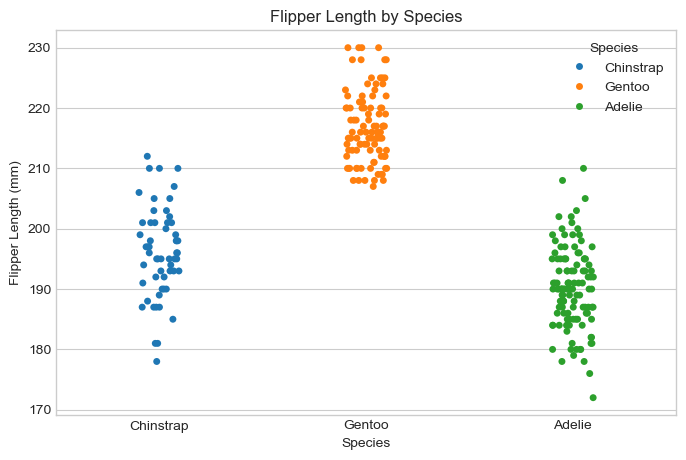

In [164]:
# explore the species groups by flipper length
plt.figure(figsize=(8, 5))
sns.stripplot(x = "Species", y = "Flipper Length (mm)", data = df, hue = "Species", legend = "brief")
plt.title("Flipper Length by Species")
plt.show()

Grouping by species and analyzing flipper length clearly distinguishes Gentoo penguins, as they generally have longer flippers than Chinstrap and Adelie penguins. However, flipper length is not a reliable identifier between Chinstrap and Adelie penguins, as their ranges overlap significantly.

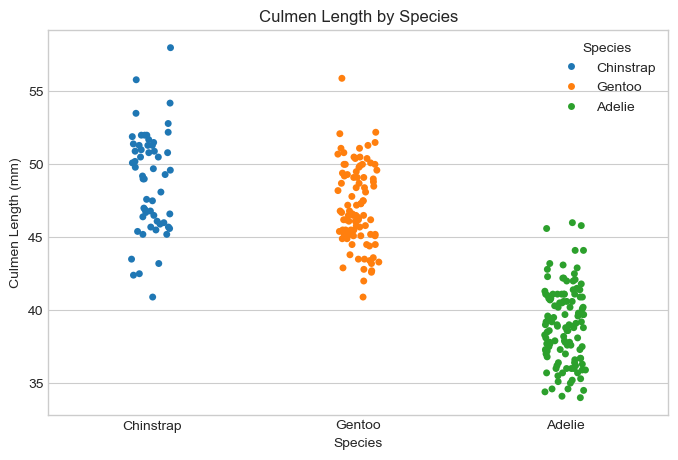

In [165]:
# explore the species groups by culmen length
plt.figure(figsize=(8, 5))
sns.stripplot(x = "Species", y = "Culmen Length (mm)", data = df, hue = "Species", legend = "brief")
plt.title("Culmen Length by Species")
plt.show()

While there is not a clear distinction between Culmen Length for Chinstrap and Gentoo penquins, there is a clear separation the two species from Adelie. This means that Culmen Length could be used as an indicator for Chinstrap penquins, in combination with island identity. 

Next we will define a method to properly give integer values to species as well as other categorical variables and apply this method to our data. 

In [166]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders for categorical variables
le = LabelEncoder()
le.fit(df["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

# Prepare data
df_train, y_train = prepare_data(df)

# Visualize our new training data
df_train.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,True,False,True,True,False
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,True,False,True,False,True
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,True,False,False,True,False,True,False,True
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,True,False,False,True,False,True,True,False
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,True,False,True,False,True


<Axes: xlabel='Culmen Length (mm)', ylabel='Flipper Length (mm)'>

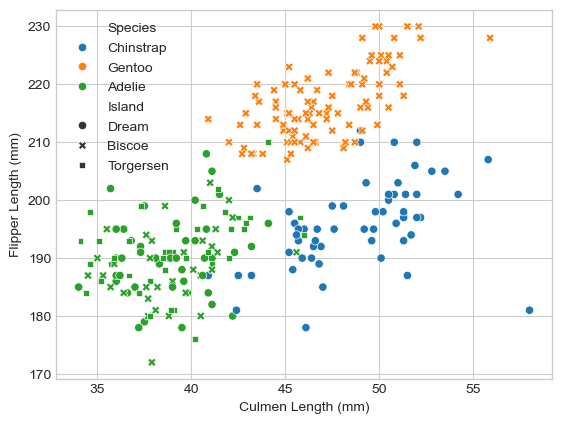

In [167]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC # support vector classifier

# Select the columns we want and separate into predictors
predictor_cols = ["Culmen Length (mm)", "Flipper Length (mm)", "Island_Biscoe", "Island_Torgersen", "Island_Dream"]

X_train = df_train[predictor_cols]

# Visualize our training dataset 1
sns.scatterplot(data = df, x = "Culmen Length (mm)", y = "Flipper Length (mm)", hue = "Species", style = "Island")

There seems to be separation between each group with Adelie, grouping in the bottom left, Gentto in the upper middle, and Chinstrap grouping in the bottom right. However, there is significant overlap in the middle indicating that a Linear Regression may not work. Lets try however, to fit a Linear model. 

In [168]:
LR = LogisticRegression(max_iter = 10000)
m = LR.fit(X_train, y_train)

Time to check the training accuracy of the model and cross validate. 

In [169]:
from sklearn.model_selection import cross_val_score

# load the testing data to check the accuracy of our model
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)
test["Species"] = test["Species"].str.split().str.get(0)


X_test, y_test = prepare_data(test)
X_test1 = X_test[predictor_cols]

print("Linear Regression for dataset 1 has a training accuracy of : " + str(LR.score(X_train, y_train)))

cv_scores_LR = cross_val_score(LR, X_train, y_train, cv = 5)
print("And cross validation scores: " + str(cv_scores_LR))


Linear Regression for dataset 1 has a training accuracy of : 0.9765625
And cross validation scores: [0.962 0.961 0.961 0.941 0.98 ]


Plot the decision regions for the model against the training data.

Linear Regression for dataset 1 has testing accuracy of: 0.9705882352941176


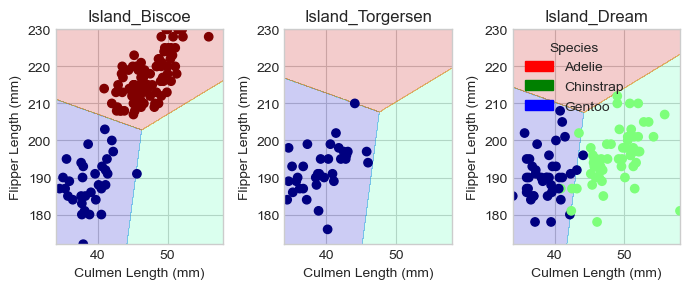

In [170]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

plot_regions(LR, X_train, y_train)

# Check the model accuracy against the testing data
print("Linear Regression for dataset 1 has testing accuracy of: " + str(LR.score(X_test1, y_test)))

Linear regression with the current parameters did not result in a 100% testing accuracy. Lets try switching out our qualitative parameter to clutch completion.

<Axes: xlabel='Culmen Length (mm)', ylabel='Flipper Length (mm)'>

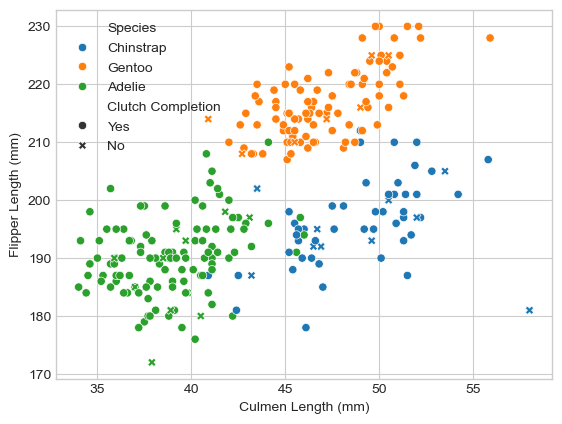

In [171]:
# Select the columns we want and separate into predictors
predictor_cols2 = ["Culmen Length (mm)", "Flipper Length (mm)", "Clutch Completion_No", "Clutch Completion_Yes"]

X_train2 = df_train[predictor_cols2]

# Visualize our training dataset 1
sns.scatterplot(data = df, x = "Culmen Length (mm)", y = "Flipper Length (mm)", hue = "Species", style = "Clutch Completion")

Time to fit the new Linear Regression Model. This model may actually be less accurate than the model taking into account island, as clutch completion seems to be mixed more evenly between penquin species compared to origin island which had some degree of specification.

In [172]:
LR2 = LogisticRegression(max_iter = 10000)
m2 = LR2.fit(X_train2, y_train)

Check the new training accuracy and cross validate. Then look at the decision region for the new model.

Linear Regression for dataset 2 has a training accuracy of: 0.95703125
And cross validation scores: [0.962 0.941 0.961 0.922 0.98 ]
Linear Regression for dataset 2 has a testing accuracy of: 0.9558823529411765


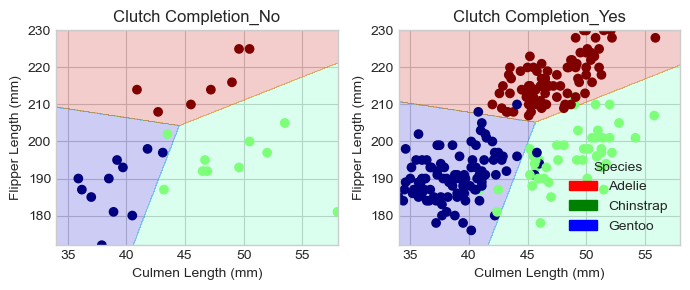

In [173]:
print("Linear Regression for dataset 2 has a training accuracy of: " + str(LR2.score(X_train2, y_train)))

cv_scores_LR2 = cross_val_score(LR2, X_train2, y_train, cv = 5)
print("And cross validation scores: " + str(cv_scores_LR2))

plot_regions(LR2, X_train2, y_train)

# Check the model accuracy against the testing data
X_test2 = X_test[predictor_cols2]

print("Linear Regression for dataset 2 has a testing accuracy of: " + str(LR2.score(X_test2, y_test)))

Unfortunately, changing the qualitative indicator for this model did not result in a testing accuracty of 100%, in fact it decreased the accuracy by ~ 2%. Let's return to island as the qualitative predictors and explore other quantitative predictors.

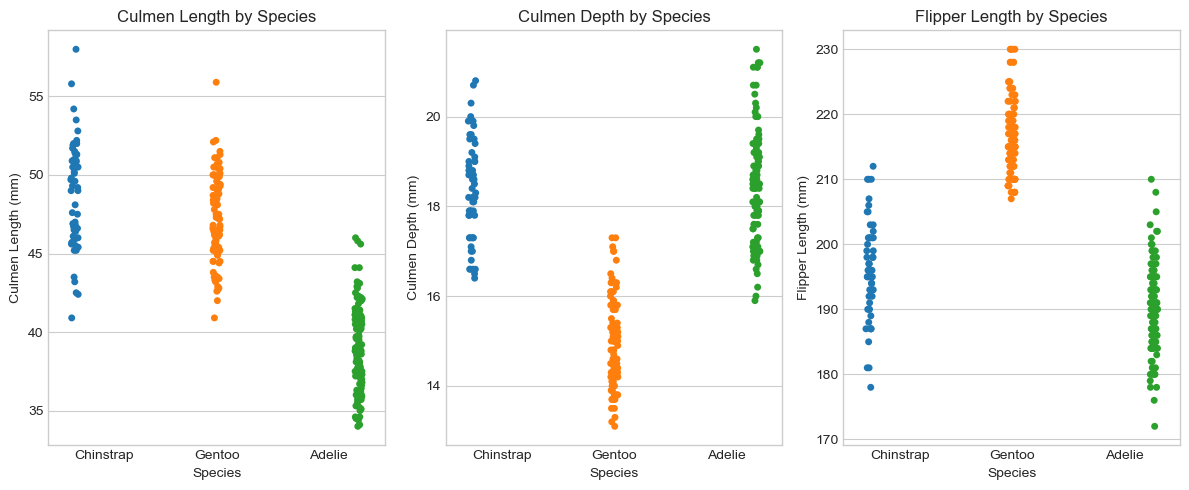

In [174]:
# explore the species groups by culmen length
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

sns.stripplot(x = "Species", y = "Culmen Length (mm)", data = df, hue = "Species", ax = axes[0], dodge = True)
axes[0].set_title("Culmen Length by Species")

sns.stripplot(x = "Species", y = "Culmen Depth (mm)", data = df, hue = "Species", ax = axes[1], dodge = True, legend = False)
axes[1].set_title("Culmen Depth by Species")

sns.stripplot(x = "Species", y = "Flipper Length (mm)", data = df, hue = "Species", ax = axes[2], dodge = True, legend = False)
axes[2].set_title("Flipper Length by Species")

plt.tight_layout()
plt.show()

Looking at these plots side by side Culmen Depth and Flipper Length have almost inverse plots, perhaps these two in combination with Island would serve as a better model than with Culmen Length and Flipper Length. Visualize the third batch of training data.

<Axes: xlabel='Culmen Depth (mm)', ylabel='Flipper Length (mm)'>

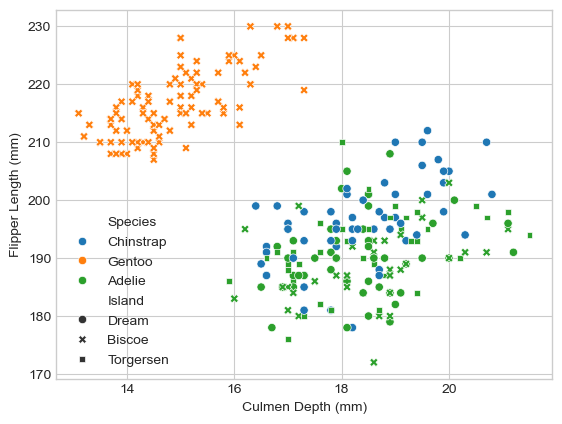

In [175]:
# Select the columns we want and separate into predictors
predictor_cols3 = ["Culmen Depth (mm)", "Flipper Length (mm)", "Island_Biscoe", "Island_Torgersen", "Island_Dream"]

X_train3 = df_train[predictor_cols3]

# Visualize our training dataset 1
sns.scatterplot(data = df, x = "Culmen Depth (mm)", y = "Flipper Length (mm)", hue = "Species", style = "Island")

Visually there is a large separation between Gentoo and the other species, however there is almost no separation between Chinstrap and Adelie. I'll try a Linear Regression but a different ML model may be more appropriate. The separation of Gentoo is promising however. 

In [176]:
LR3 = LogisticRegression(max_iter = 10000)
m3 = LR3.fit(X_train3, y_train)

Check the new training accuracy and cross validate. Then look at the decision region for the new model.

Linear Regression for dataset 3 has a training accuracy of: 0.8828125
And cross validation scores: [0.827 0.902 0.902 0.863 0.922]
Linear Regression for dataset 3 has a testing accuracy of: 0.8970588235294118


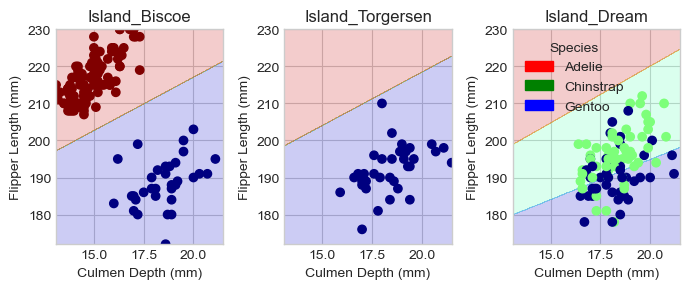

In [177]:
print("Linear Regression for dataset 3 has a training accuracy of: " + str(LR3.score(X_train3, y_train)))

cv_scores_LR3 = cross_val_score(LR3, X_train3, y_train, cv = 5)
print("And cross validation scores: " + str(cv_scores_LR3))

plot_regions(LR3, X_train3, y_train)

# Check the model accuracy against the testing data
X_test3 = X_test[predictor_cols3]

print("Linear Regression for dataset 3 has a testing accuracy of: " + str(LR3.score(X_test3, y_test)))

Linear Regression clearly does not work for these parameters, however the clear separation between Gentoo is promising and other machine learning models should be considered. Lets try a DecisionTree Classifier with the two datasets involving Island as our qualitative indicator.

In [178]:
from sklearn.tree import DecisionTreeClassifier

reg1_1 = DecisionTreeClassifier(max_depth = 1)
reg1_5 = DecisionTreeClassifier(max_depth = 5)
reg2_1 = DecisionTreeClassifier(max_depth = 1)
reg2_5 = DecisionTreeClassifier(max_depth = 5)

# time to fit a decision tree classifier with depth 1 and 5 to both our datasets with Island as the qualitative indicator
reg1_1.fit(X_train, y_train)
reg1_5.fit(X_train, y_train)
reg2_1.fit(X_train3, y_train)
reg2_5.fit(X_train3, y_train)

# Check the training accuracy and cross validate each model
print("DecisionTreeClassifier with depth = 1 has a training accuracy of: " + str(reg1_1.score(X_train, y_train)) + " for dataset 1")

cv_reg1_1 = cross_val_score(reg1_1, X_train, y_train, cv = 5)
print("And a cross validation of: " + str(cv_reg1_1) + "\n")

print("DecisionTreeClassifier with depth = 5 has a training accuracy of: " + str(reg1_5.score(X_train, y_train)) + " for dataset 1")

cv_reg1_5 = cross_val_score(reg1_5, X_train, y_train, cv = 5)
print("And a cross validation of: " + str(cv_reg1_5) + "\n")

print("DecisionTreeClassifier with depth = 1 has a training accuracy of: " + str(reg2_1.score(X_train3, y_train)) + " for dataset 3")

cv_reg2_1 = cross_val_score(reg2_1, X_train3, y_train, cv = 5)
print("And a cross validation of: " + str(cv_reg2_1) + "\n")

print("DecisionTreeClassifier with depth = 5 has a training accuracy of: " + str(reg2_5.score(X_train3, y_train)) + " for dataset 3")

cv_reg2_5 = cross_val_score(reg2_5, X_train3, y_train, cv = 5)
print("And a cross validation of: " + str(cv_reg2_5) + "\n")



DecisionTreeClassifier with depth = 1 has a training accuracy of: 0.7734375 for dataset 1
And a cross validation of: [0.769 0.765 0.765 0.765 0.784]

DecisionTreeClassifier with depth = 5 has a training accuracy of: 0.9921875 for dataset 1
And a cross validation of: [0.981 0.98  0.961 0.961 1.   ]

DecisionTreeClassifier with depth = 1 has a training accuracy of: 0.7734375 for dataset 3
And a cross validation of: [0.769 0.765 0.765 0.765 0.784]

DecisionTreeClassifier with depth = 5 has a training accuracy of: 0.9140625 for dataset 3
And a cross validation of: [0.865 0.863 0.863 0.882 0.902]



Based on training accuracy and cross validation model 2 (dataset 1 with depth = 5) seems to be the most promising. Lets check the decision region and accuracy against the testing data. 

Dataset 1 with depth = 5 has testing accuracy: 0.9852941176470589


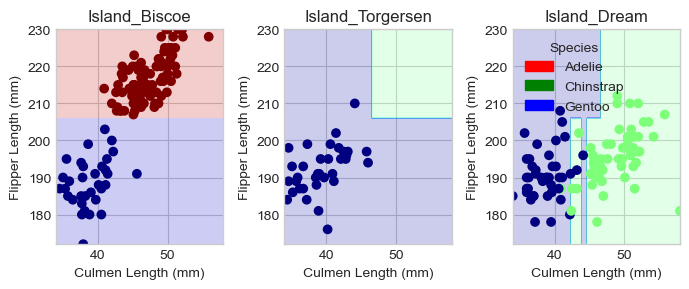

In [179]:
plot_regions(reg1_5, X_train, y_train)

# Check the model accuracy against the testing data
print("Dataset 1 with depth = 5 has testing accuracy: " + str(reg1_5.score(X_test1, y_test)))

Perhaps this model was overfit to the data. Lets examine the model with the second highest training accuracy (model 4: dataset 3 with depth  = 5).

Dataset 3 with depth = 5 has testing accuracy: 0.8676470588235294


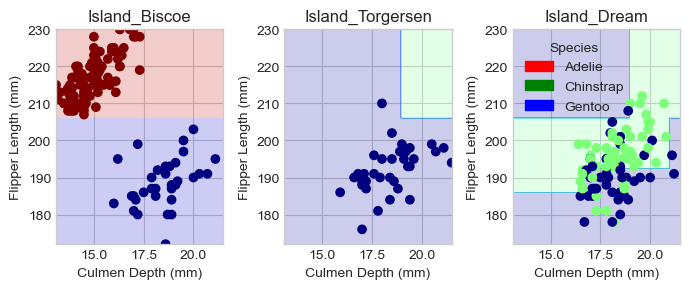

In [180]:
plot_regions(reg2_5, X_train3, y_train)

# Check the model accuracy against the testing data
print("Dataset 3 with depth = 5 has testing accuracy: " + str(reg2_5.score(X_test3, y_test)))

The accuracy of the models using dataset 3 were not as good as the models for dataset 1. We will now try additional model complexities in between 1 and 5 on dataset 1 to see if there is a more optimal model depth. 

In [181]:
reg1_2 = DecisionTreeClassifier(max_depth = 2)
reg1_3 = DecisionTreeClassifier(max_depth = 3)
reg1_4 = DecisionTreeClassifier(max_depth = 4)

reg1_2.fit(X_train, y_train)
reg1_3.fit(X_train, y_train)
reg1_4.fit(X_train, y_train)


print("DecisionTreeClassifier with depth = 2 has a training accuracy of: " + str(reg1_2.score(X_train, y_train)) + " for dataset 1")

cv_reg1_2 = cross_val_score(reg1_2, X_train, y_train, cv = 5)
print("And a cross validation of: " + str(cv_reg1_2) + "\n")

print("DecisionTreeClassifier with depth = 3 has a training accuracy of: " + str(reg1_3.score(X_train, y_train)) + " for dataset 1")

cv_reg1_3 = cross_val_score(reg1_3, X_train, y_train, cv = 5)
print("And a cross validation of: " + str(cv_reg1_3) + "\n")

print("DecisionTreeClassifier with depth = 4 has a training accuracy of: " + str(reg1_4.score(X_train, y_train)) + " for dataset 1")

cv_reg1_4 = cross_val_score(reg1_4, X_train, y_train, cv = 5)
print("And a cross validation of: " + str(cv_reg1_4) + "\n")

# test the accuracy for each model of varying depth against the test data
print("Testing the model with complexity 2: " + str(reg1_2.score(X_test1, y_test)) + "\n")
print("Testing the model with complexity 3: " + str(reg1_3.score(X_test1, y_test)) + "\n")
print("Testing the model with complexity 4: " + str(reg1_4.score(X_test1, y_test)) + "\n")

DecisionTreeClassifier with depth = 2 has a training accuracy of: 0.9609375 for dataset 1
And a cross validation of: [0.981 0.902 0.961 0.902 0.98 ]

DecisionTreeClassifier with depth = 3 has a training accuracy of: 0.98046875 for dataset 1
And a cross validation of: [0.981 0.98  0.941 0.941 0.98 ]

DecisionTreeClassifier with depth = 4 has a training accuracy of: 0.98828125 for dataset 1
And a cross validation of: [0.981 0.98  0.961 0.961 1.   ]

Testing the model with complexity 2: 0.9558823529411765

Testing the model with complexity 3: 0.9705882352941176

Testing the model with complexity 4: 0.9852941176470589



It seems that the higher model complexity is yielding better training accuracy and testing accuracy. Lets try the extremes of complexity on dataset 1, even though this may result in overfitting to the training data.

In [182]:
reg1_25 = DecisionTreeClassifier(max_depth = 25)
reg1_100 = DecisionTreeClassifier(max_depth = 100)
reg1_500 = DecisionTreeClassifier(max_depth = 500)

reg1_25.fit(X_train, y_train)
reg1_100.fit(X_train, y_train)
reg1_500.fit(X_train, y_train)


print("DecisionTreeClassifier with depth = 25 has a training accuracy of: " + str(reg1_25.score(X_train, y_train)) + " for dataset 1")

cv_reg1_25 = cross_val_score(reg1_25, X_train, y_train, cv = 5)
print("And a cross validation of: " + str(cv_reg1_25) + "\n")

print("DecisionTreeClassifier with depth = 100 has a training accuracy of: " + str(reg1_100.score(X_train, y_train)) + " for dataset 1")

cv_reg1_100 = cross_val_score(reg1_100, X_train, y_train, cv = 5)
print("And a cross validation of: " + str(cv_reg1_100) + "\n")

print("DecisionTreeClassifier with depth = 500 has a training accuracy of: " + str(reg1_500.score(X_train, y_train)) + " for dataset 1")

cv_reg1_500 = cross_val_score(reg1_500, X_train, y_train, cv = 5)
print("And a cross validation of: " + str(cv_reg1_500) + "\n")

# test the accuracy for each model of varying depth against the test data
print("Testing the model with complexity 25: " + str(reg1_25.score(X_test1, y_test)) + "\n")
print("Testing the model with complexity 100: " + str(reg1_100.score(X_test1, y_test)) + "\n")
print("Testing the model with complexity 500: " + str(reg1_500.score(X_test1, y_test)) + "\n")

DecisionTreeClassifier with depth = 25 has a training accuracy of: 1.0 for dataset 1
And a cross validation of: [0.981 0.98  0.98  0.961 0.98 ]

DecisionTreeClassifier with depth = 100 has a training accuracy of: 1.0 for dataset 1
And a cross validation of: [0.981 0.98  0.941 0.98  0.98 ]

DecisionTreeClassifier with depth = 500 has a training accuracy of: 1.0 for dataset 1
And a cross validation of: [0.981 0.98  0.941 0.941 0.98 ]

Testing the model with complexity 25: 0.9705882352941176

Testing the model with complexity 100: 0.9852941176470589

Testing the model with complexity 500: 0.9852941176470589



100% training accuracy and extremely high accuracy in cross-validation likely means we are overfitting the model to the training data, preventing us from generalizing the model to the test data resulting in lower testing accuracy. This was expcted. Lets try making a new dataset and only looking at Culmen measurements instead of including Flipper Length as a measurment. We will try both Linear Regression as well as a Decision Tree Classifier with depths of 3,4, & 5 as those depth values produced the highest testing accuracy on dataset 1. 

<Axes: xlabel='Culmen Depth (mm)', ylabel='Culmen Length (mm)'>

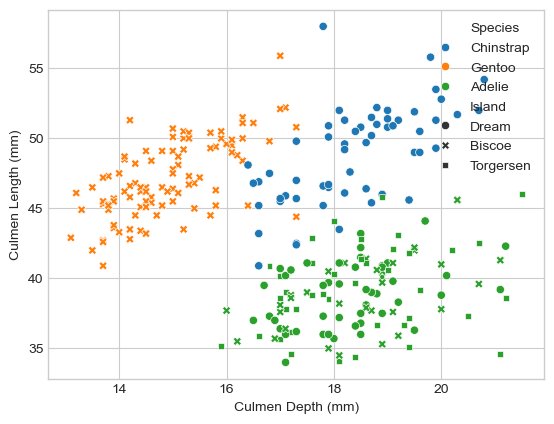

In [183]:
# Select the columns we want and separate into predictors
predictor_cols4 = ["Culmen Depth (mm)", "Culmen Length (mm)", "Island_Biscoe", "Island_Torgersen", "Island_Dream"]

X_train4 = df_train[predictor_cols4]

# Visualize our training dataset 4
sns.scatterplot(data = df, x = "Culmen Depth (mm)", y = "Culmen Length (mm)", hue = "Species", style = "Island", legend = "brief")

Our fourth batch of data present three fairly clear groups. Gentoo penquins cluster in the upper length, and excuslively belong to Biscoe Island. Chinstrap penquins cluster in between the other two groups, and exclusively belong to Dream Island. While, Adelie penguins can be found at every island, they have a fairly distinct cluster in the bottom right. This data clustering, while it presents some overlap, is extremely promising based on the clustering patterns especially with regard to islands for Gentoo and Chinstrap penquins. 

In [184]:
LR4 = LogisticRegression(max_iter = 10000)
m4 = LR4.fit(X_train4, y_train)

Check the new model against the training data and cross validate. Then plot the decision region and check the model against the test data

Linear Regression for dataset 4 has a training accuracy of: 0.99609375
And cross validation scores: [0.981 1.    1.    0.941 1.   ]
Linear Regression for dataset 2 has a testing accuracy of: 1.0


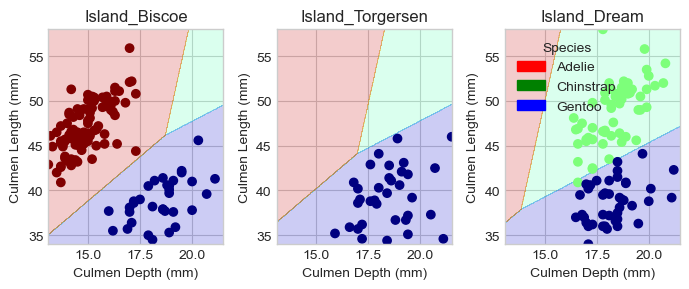

In [ ]:
print("Linear Regression for dataset 4 has a training accuracy of: " + str(LR4.score(X_train4, y_train)))

cv_scores_LR4 = cross_val_score(LR4, X_train4, y_train, cv = 5)
print("And cross validation scores: " + str(cv_scores_LR4))

plot_regions(LR4, X_train4, y_train)

# Check the model accuracy against the testing data
X_test4 = X_test[predictor_cols4]

print("Linear Regression for dataset 4 has a testing accuracy of: " + str(LR4.score(X_test4, y_test)))

Confusion Matrix For the Model:
[[31  0  0]
 [ 0 11  0]
 [ 0  0 26]]


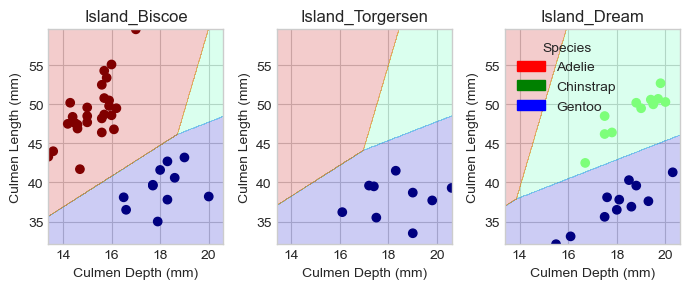

In [193]:
# Lets view the confusion matrix for our succesfull model
from sklearn.metrics import confusion_matrix

y_test_pred = LR4.predict(X_test4)
C = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix For the Model:\n" + str(C))

# Lets also look at the decision regions for the model evaluated on the test set
plot_regions(LR4, X_test4, y_test)

100% accuracy has been achieved! We have now developed a model with 100% testing accuracy for identifying Palmer Penquins based on physiologcal characteristics. If you ran this code yourself and did not achieve 100% accuracy on one of these models, re-run the code with new training and testing data (this will produce a model with 100% testing accuracy after 2 - 3 tries if not on the first). Since it was mentioned above, lets run the DecisionTreeClassifiers for fun. 

DecisionTreeClassifier with depth = 3 has a training accuracy of: 0.98828125 for dataset 4
And a cross validation of: [0.981 1.    0.98  0.941 0.941]

DecisionTreeClassifier with depth = 4 has a training accuracy of: 0.9921875 for dataset 4
And a cross validation of: [0.981 1.    0.98  0.941 0.941]

DecisionTreeClassifier with depth = 5 has a training accuracy of: 1.0 for dataset 4
And a cross validation of: [0.981 1.    0.98  0.941 0.961]

Testing the model with complexity 3: 0.9852941176470589

Testing the model with complexity 4: 0.9852941176470589

Testing the model with complexity 5: 0.9852941176470589



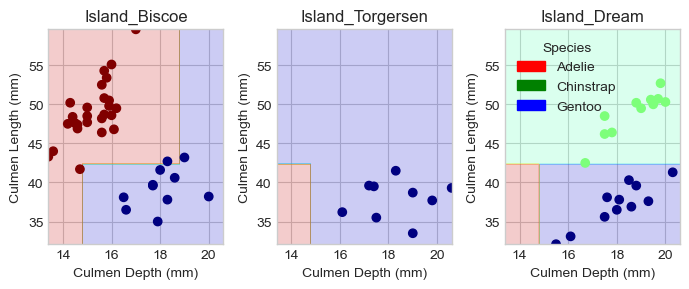

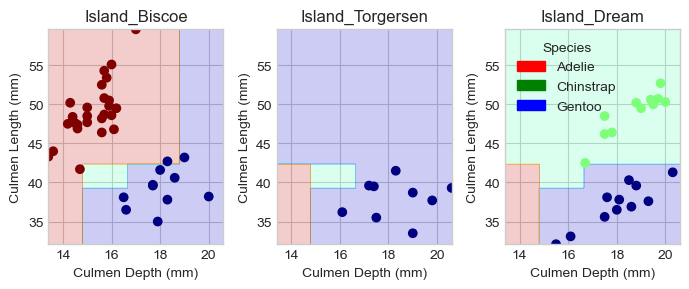

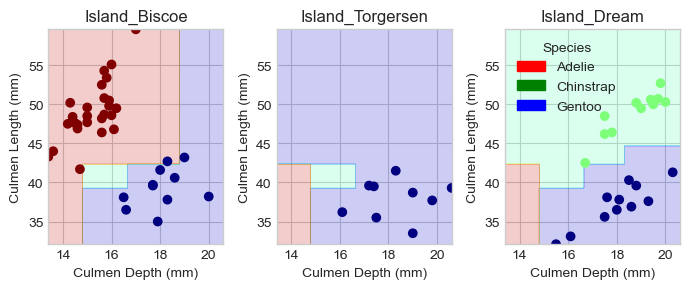

In [194]:
reg4_3 = DecisionTreeClassifier(max_depth = 3)
reg4_4 = DecisionTreeClassifier(max_depth = 4)
reg4_5 = DecisionTreeClassifier(max_depth = 5)

reg4_3.fit(X_train4, y_train)
reg4_4.fit(X_train4, y_train)
reg4_5.fit(X_train4, y_train)


print("DecisionTreeClassifier with depth = 3 has a training accuracy of: " + str(reg4_3.score(X_train4, y_train)) + " for dataset 4")

cv_reg4_3 = cross_val_score(reg4_3, X_train4, y_train, cv = 5)
print("And a cross validation of: " + str(cv_reg4_3) + "\n")

print("DecisionTreeClassifier with depth = 4 has a training accuracy of: " + str(reg4_4.score(X_train4, y_train)) + " for dataset 4")

cv_reg4_4 = cross_val_score(reg4_4, X_train4, y_train, cv = 5)
print("And a cross validation of: " + str(cv_reg4_4) + "\n")

print("DecisionTreeClassifier with depth = 5 has a training accuracy of: " + str(reg4_5.score(X_train4, y_train)) + " for dataset 4")

cv_reg4_5 = cross_val_score(reg4_5, X_train4, y_train, cv = 5)
print("And a cross validation of: " + str(cv_reg4_5) + "\n")

# Plot Each Decision Region For the Decision Tree Models

plot_regions(reg4_3, X_test4, y_test)

plot_regions(reg4_4, X_test4, y_test)

plot_regions(reg4_5, X_test4, y_test)


# test the accuracy for each model of varying depth against the test data
print("Testing the model with complexity 3: " + str(reg4_3.score(X_test4, y_test)) + "\n")
print("Testing the model with complexity 4: " + str(reg4_4.score(X_test4, y_test)) + "\n")
print("Testing the model with complexity 5: " + str(reg4_5.score(X_test4, y_test)) + "\n")

These models will also achieve 100% testing accuracy depending on how the model adapts to the training data and may need to be refresehd a few times to achieve the 100% testing mark on your own machine. 

Through the process of analyzing the Palmer Penguins dataset, several key insights were uncovered regarding the classification of penguin species based on their physical characteristics. First, identify the quantitative features which created the clearest three groupings was key. In fact, more time should have been spent in the beginning graphing out possible combinations of quantitative features; this process may have more quickly identified Culmen Length and Depth as the best features for clustering penquin species together. Plotting tables for the qualitative features also proved key, as it quickly identified that Island was a good indicator of species. In addition, when dealing with models such as the DecisionTreeClassifier utilizing the cross validation as a check for overfitting helped identify the correct depth range for our models, as lower values procuded worse testing accuracy, but the extremely high complexity values produced overfitted results. Finally, as a general note, I would spend more time in the beginning exploring potential data combinations via graphical methods in order to more quickly identify the predicators which might work best rather than plug and chug; I did, however, enjoy the process of tinkering with the different models and datasets until I found the perfect one. 